# Video stream train

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path

from keras.layers.core import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [3]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


## Dataset creation

Nico 
0: angry
1: calm
2: disgust
3: fear
4: happy
5: sad
6: surprise

In [4]:
emotions_tras = {1:1, 2:4, 3:5, 4:0, 5:3, 6:2, 7:6}
emotions = {0:'angry', 1:'calm', 2:'disgust', 3:'fear', 4:'happy', 5:'sad', 6:'surprise'}

# emotions = {0:'neutral', 1:'calm', 2:'happy', 3:'sad', 4:'angry', 5:'fear', 6:'disgust', 7:'surprise'}
# emotional_intensity = {1:'normal', 2:'strong'}

dataset_path = "Datasets/RAVDESS_frames/"

height_orig = 224
width_orig = 224
height_targ = 112
width_targ = 112

batch_size = 64
num_classes = len(emotions)

val_actors = ['21', '22']
test_actors = ['23', '24']

In [5]:
filenames_train = [] # train
filenames_val = [] # validation

for (dirpath, dirnames, fn) in os.walk(dataset_path):
    if fn != []:
        class_temp = int(fn[0].split('-')[2]) - 1
        if class_temp != 0:                                                     # exclude 'neutral' label
            if any(act in dirpath for act in (test_actors+val_actors))==False:  # select only train actors
                path = [os.path.join(dirpath, elem) for elem in fn]
                label = [emotions_tras[class_temp]] * len(fn)                   # emotion transposition
                filenames_train.append(list(zip(path, label)))
            
            if any(act in dirpath for act in val_actors):                       # select only validation actors
                path = [os.path.join(dirpath, elem) for elem in fn]
                label = [emotions_tras[class_temp]] * len(fn)
                filenames_val.append(list(zip(path, label)))

In [6]:
# image = tf.io.read_file(filenames_train[0][0][0])
# image = tf.image.decode_jpeg(image, channels=3)
# image = tf.image.convert_image_dtype(image, dtype=tf.float16)
# image = tf.image.resize(image, [height_orig, width_orig])

# image = image.numpy()
# for i, elem in enumerate(image):
#     for j, val in enumerate(elem):
#         if np.sum(val) > 2.7:
#             image[i][j] = np.array([0, 0, 0])
# image = tf.convert_to_tensor(image)

# plt.imshow(image)

In [7]:
# image = tf.io.read_file("C:\\Users\\gianl\\Desktop\\Uni Bicocca\\GitHub\\Digital_signals_project\\Datasets\\RAVDESS_frames\\Actor_03\\01-01-01-01-02-01-03\\01-01-01-01-02-01-03_24.png")
# image = tf.image.decode_jpeg(image, channels=1)
# image = tf.image.convert_image_dtype(image, dtype=tf.float16)
# image = tf.image.resize_with_crop_or_pad(image, height_orig, width_orig)
# image = tf.image.resize(image, [height_targ, width_targ])
# image

In [8]:
def sampling(list, num_frames_desired):
    tot = []
    for elem in list:
        sampled_list = random.sample(elem, num_frames_desired)
        tot += sampled_list
    return(tot)

def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=1) # BW
    image = tf.image.convert_image_dtype(image, dtype=tf.float16)
    image = tf.image.resize_with_crop_or_pad(image, height_orig, width_orig)
    image = tf.image.resize(image, [height_targ, width_targ])
    print('shape frames:', image.shape)
    return image

def configure_for_performance(ds):
    ds = ds.shuffle(buffer_size=1000) # serve?
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

def load_dataset(filenames, batch_size):
    frames_per_vid = min([len(elem) for elem in filenames])     # number of frames per clip in order to have balanced classes
    print("frames per video:", frames_per_vid) 

    filenames_sampled = sampling(filenames, frames_per_vid)
    random.shuffle(filenames_sampled)

    zipped = [list(t) for t in zip(*filenames_sampled)]

    names = zipped[0]
    labels = zipped[1]

    names = tf.data.Dataset.from_tensor_slices(names)
    images = names.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    labels = [elem for elem in labels]
    labels = tf.data.Dataset.from_tensor_slices(labels)

    ds = tf.data.Dataset.zip((images, labels))
    ds = configure_for_performance(ds)

    frame_number = len(filenames_sampled)
    step_per_epoch = frame_number // batch_size
    print('frames number:', frame_number, '\nbatch size:', batch_size, '\nbatch number:', step_per_epoch)
    return ds, step_per_epoch

In [9]:
train_ds, step_per_epoch_train = load_dataset(filenames_train, batch_size)

frames per video: 23
shape frames: (112, 112, 1)
frames number: 25760 
batch size: 64 
batch number: 402


In [10]:
val_ds, step_per_epoch_val = load_dataset(filenames_val, batch_size)

frames per video: 28
shape frames: (112, 112, 1)
frames number: 3136 
batch size: 64 
batch number: 49


(112, 112, 1)
disgust


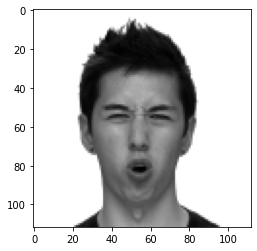

In [13]:
b = val_ds.unbatch().take(1)

for elem in b:
    print(elem[0].shape)
    print(emotions[int(elem[1])])
plt.imshow(elem[0], cmap='gray')

(112, 112, 1)
surprise


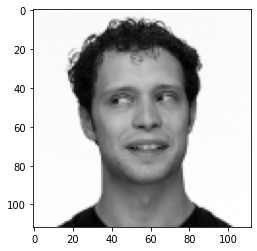

In [17]:
a = train_ds.unbatch().take(1)

for elem in a:
    print(elem[0].shape)
    print(emotions[int(elem[1])])
plt.imshow(elem[0], cmap='gray')

In [18]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.04),
    layers.RandomZoom(height_factor=(-0.1, 0.1))
])

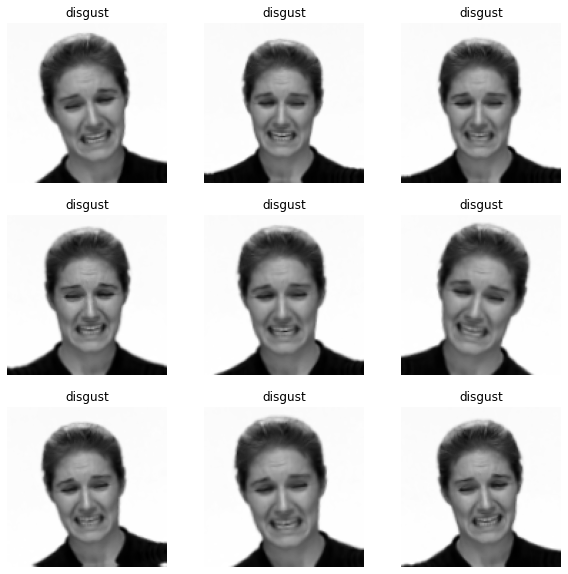

In [19]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    # print(labels)
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0], cmap='gray')
        plt.title(emotions[int(labels[0])])
        plt.axis("off")

## Network from scratch

In [41]:
from datetime import datetime

checkpoint_filepath = f'./Models/Video_stream/video_model_{datetime.now().strftime("%d-%m-%y_%H-%M")}_' + '[{val_sparse_categorical_accuracy:.4f}].hdf5'

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_sparse_categorical_accuracy", factor=0.5, patience=2, verbose=1)
early_stop = keras.callbacks.EarlyStopping( monitor="val_sparse_categorical_accuracy", patience=4, verbose=1, restore_best_weights=True)
save_best = keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                            monitor='val_sparse_categorical_accuracy',
                                            mode='max',
                                            save_best_only=True)

In [40]:
# version = 3
arc = ''
epochs = 7
lr = 0.001
momentum = 0.5

In [57]:
## Model ??% accuracy

def build_model(hp):
    net = Sequential(name='DCNN')

    net.add(
        keras.layers.Conv2D(
            filters=16,
            kernel_size=(8,8),
            input_shape=(width_targ, height_targ, 1),
            padding='same',
            activation='relu',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )

    net.add(keras.layers.MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))

    net.add(
        keras.layers.Conv2D(
            filters=32,
            kernel_size=(4,4),
            input_shape=(width_targ, height_targ, 1),
            padding='same',
            activation='relu',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    # net.add(keras.layers.BatchNormalization(name='batchnorm_1'))

    net.add(keras.layers.MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            48,
            activation='relu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    # net.add(keras.layers.Dropout(1, name='dropout_3'))

    # net.add(keras.layers.BatchNormalization(name='batchnorm_7'))

    # net.add(keras.layers.Dropout(0.6, name='dropout_4'))

    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )

    net.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        # optimizer=keras.optimizers.SGD(learning_rate=learningrate, momentum=momentum)
        loss=keras.losses.sparse_categorical_crossentropy,
        metrics=[keras.metrics.sparse_categorical_accuracy],
    )
    return net

In [50]:
## Model ~40% accuracy

def build_model(hp):
    net = Sequential(name='DCNN')

    net.add(
        keras.layers.Conv2D(
            filters=32,
            kernel_size=(3,3),
            input_shape=(width_targ, height_targ, 1),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(keras.layers.BatchNormalization(name='batchnorm_1'))

    net.add(
        keras.layers.Conv2D(
            filters=32,
            kernel_size=(3,3),
            input_shape=(width_targ, height_targ, 1),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_11'
        )
    )
    net.add(keras.layers.BatchNormalization(name='batchnorm_11'))

    net.add(keras.layers.MaxPooling2D(pool_size=(2,2), name='maxpool2d_0'))
    net.add(
        keras.layers.Conv2D(
            filters=64,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(keras.layers.BatchNormalization(name='batchnorm_2'))

    net.add(keras.layers.MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(keras.layers.Dropout(0.4, name='dropout_1'))

    # net.add(
    #     keras.layers.Conv2D(
    #         filters=128,
    #         kernel_size=(3,3),
    #         activation='elu',
    #         padding='same',
    #         kernel_initializer='he_normal',
    #         name='conv2d_3'
    #     )
    # )
    # net.add(keras.layers.BatchNormalization(name='batchnorm_3'))
    net.add(
        keras.layers.Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(keras.layers.BatchNormalization(name='batchnorm_4'))

    net.add(keras.layers.MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(keras.layers.Dropout(0.4, name='dropout_2'))

    net.add(
        keras.layers.Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(keras.layers.BatchNormalization(name='batchnorm_5'))

    net.add(keras.layers.MaxPooling2D(pool_size=(2,2), name='maxpool2d_21'))
    net.add(keras.layers.Dropout(0.4, name='dropout_21'))

    net.add(
        keras.layers.Conv2D(
            filters=512,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_51'
        )
    )
    net.add(keras.layers.BatchNormalization(name='batchnorm_51'))
    # net.add(
    #     keras.layers.Conv2D(
    #         filters=256,
    #         kernel_size=(3,3),
    #         activation='elu',
    #         padding='same',
    #         kernel_initializer='he_normal',
    #         name='conv2d_6'
    #     )
    # )
    # net.add(keras.layers.BatchNormalization(name='batchnorm_6'))

    net.add(keras.layers.MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(keras.layers.Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(keras.layers.BatchNormalization(name='batchnorm_7'))

    net.add(keras.layers.Dropout(0.6, name='dropout_4'))

    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )

    net.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        # optimizer=keras.optimizers.SGD(learning_rate=learningrate, momentum=momentum)
        loss=keras.losses.sparse_categorical_crossentropy,
        metrics=[keras.metrics.sparse_categorical_accuracy],
    )
    return net

In [ ]:
import keras_tuner
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_sparse_categorical_accuracy",
    # max_trials=3,
    executions_per_trial=1,
    overwrite=True,
)

tuner.search_space_summary()

In [ ]:
tuner.search(train_ds,
             epochs=3,
             validation_data=val_ds,
             batch_size=batch_size,
             steps_per_epoch=step_per_epoch_train,
             validation_steps=step_per_epoch_val)

In [ ]:
tuner.get_best_hyperparameters()[0].values

{'num_kernel': 4}

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build()
# best_model.summary()

In [58]:
net = build_model(0)
net.summary()

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 112, 112, 16)      1040      
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 56, 56, 16)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        8224      
                                                                 
 maxpool2d_2 (MaxPooling2D)  (None, 28, 28, 32)        0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 48)                1204272   
                                                                 
 out_layer (Dense)           (None, 7)                 343    

In [59]:
history = net.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    batch_size=batch_size,
                    steps_per_epoch=step_per_epoch_train,
                    validation_steps=step_per_epoch_val,
                    # callbacks=[reduce_lr, early_stop, save_best],
                    callbacks=[save_best, reduce_lr],
                    verbose=1)

Epoch 1/7
402/402 [==============================] - 17s 39ms/step - loss: 1.2258 - sparse_categorical_accuracy: 0.5677 - val_loss: 3.5220 - val_sparse_categorical_accuracy: 0.2197 - lr: 0.0010
Epoch 2/7
402/402 [==============================] - 18s 44ms/step - loss: 0.3657 - sparse_categorical_accuracy: 0.8818 - val_loss: 4.4480 - val_sparse_categorical_accuracy: 0.2146 - lr: 0.0010
Epoch 3/7
402/402 [==============================] - 18s 44ms/step - loss: 0.1820 - sparse_categorical_accuracy: 0.9442 - val_loss: 5.1898 - val_sparse_categorical_accuracy: 0.2350 - lr: 0.0010
Epoch 4/7
401/402 [============================>.] - ETA: 0s - loss: 0.1044 - sparse_categorical_accuracy: 0.9680

KeyboardInterrupt: 

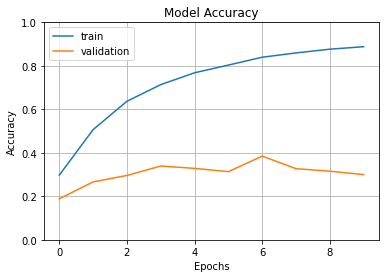

In [35]:
fig1 = plt.gcf()
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.axis(ymin=0, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
# plt.savefig('./Report/Plots/resnet1_2.png')
plt.show()

## Prove

In [21]:
# def build_model(hp):
net = Sequential(name='DCNN')

net.add(
    keras.layers.Conv2D(
        filters=32,
        kernel_size=(5,5),
        input_shape=(width_targ, width_targ, 1),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_1'
    )
)
net.add(keras.layers.BatchNormalization(name='batchnorm_1'))
net.add(keras.layers.MaxPooling2D(pool_size=(2,2), name='maxpool2d_0'))
net.add(keras.layers.Dropout(0.4, name='dropout_0'))

net.add(
    keras.layers.Conv2D(
        filters=64,
        kernel_size=(5,5),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_2'
    )
)
net.add(keras.layers.BatchNormalization(name='batchnorm_2'))

net.add(keras.layers.MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
net.add(keras.layers.Dropout(0.4, name='dropout_1'))

net.add(
    keras.layers.Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_3'
    )
)
net.add(keras.layers.BatchNormalization(name='batchnorm_3'))
# net.add(
#     keras.layers.Conv2D(
#         filters=128,
#         kernel_size=(3,3),
#         activation='elu',
#         padding='same',
#         kernel_initializer='he_normal',
#         name='conv2d_4'
#     )
# )
# net.add(keras.layers.BatchNormalization(name='batchnorm_4'))

net.add(keras.layers.MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
net.add(keras.layers.Dropout(0.4, name='dropout_2'))

net.add(
    keras.layers.Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_5'
    )
)
net.add(keras.layers.BatchNormalization(name='batchnorm_5'))
net.add(
    keras.layers.Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_6'
    )
)
net.add(keras.layers.BatchNormalization(name='batchnorm_6'))

net.add(keras.layers.MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
net.add(keras.layers.Dropout(0.5, name='dropout_3'))

net.add(Flatten(name='flatten'))
    
net.add(
    Dense(
        128,
        activation='elu',
        kernel_initializer='he_normal',
        name='dense_1'
    )
)
net.add(keras.layers.BatchNormalization(name='batchnorm_7'))

net.add(keras.layers.Dropout(0.6, name='dropout_4'))

net.add(
    Dense(
        num_classes,
        activation='softmax',
        name='out_layer'
    )
)




# return net


# net.summary()

In [22]:
# def build_model(hp):
#     net = Sequential(name='DCNN')

#     net.add(
#         keras.layers.Conv2D(
#             filters=hp.Int(name = 'neuron_first', min_value = 16, max_value = 128, step = 16),
#             kernel_size=(3,3),
#             input_shape=(width_targ, height_targ, 1),
#             padding='same',
#             activation=hp.Choice("activation", ["relu", "elu"]),
#             kernel_initializer='he_normal',
#             name='conv2d_iniz'
#         )
#     )

#     net.add(keras.layers.BatchNormalization(name='batchnorm_iniz'))
#     net.add(keras.layers.MaxPooling2D(pool_size=(2,2), name='maxpool2d_iniz'))


#     for i in range(hp.Int(name = 'num_layers', min_value = 1, max_value = 3, step = 1)):
#         net.add(
#             keras.layers.Conv2D(
#                 filters=hp.Int(f"units_{i}", min_value=32, max_value=128, step=32),
#                 kernel_size=(3,3),
#                 padding='same',
#                 kernel_initializer='he_normal',
#                 name=f'conv2d_{i}'
#             )
#         )
#         net.add(keras.layers.MaxPooling2D(pool_size=(2,2), name=f'maxpool2d_{i}'))

#     net.add(Flatten(name='flatten'))
        
#     # net.add(
#     #     Dense(
#     #         128,
#     #         activation='elu',
#     #         kernel_initializer='he_normal',
#     #         name='dense_1'
#     #     )
#     # )
#     # net.add(keras.layers.BatchNormalization(name='batchnorm_7'))

#     # net.add(keras.layers.Dropout(0.6, name='dropout_4'))

#     net.add(
#         Dense(
#             num_classes,
#             activation='softmax',
#             name='out_layer'
#         )
#     )

#     # net.compile(
#     #     loss='categorical_crossentropy',
#     #     optimizer=optim,
#     #     metrics=['accuracy']
#     # )
#     net.compile(
#         optimizer=keras.optimizers.Adam(learning_rate=lr),
#         # optimizer=keras.optimizers.SGD(learning_rate=learningrate, momentum=momentum)
#         loss=keras.losses.sparse_categorical_crossentropy,
#         metrics=[keras.metrics.sparse_categorical_accuracy]
#     )

#     net.summary()
            

In [23]:
np.geomspace(16, 128, 4, endpoint = True)

array([ 16.,  32.,  64., 128.])

In [24]:
net = build_model(keras_tuner.HyperParameters())

In [25]:
# tuner = keras_tuner.Hyperband(
#     hypermodel=build_model,
#     objective = "val_accuracy"
# )
# tuner = kt.Hyperband(hypermodel = model_builder,
#                      objective = kt.Objective("val_f1", direction="max"),
#                      max_epochs = 20,
# 					 project_name='hyperband_tuner')

tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2
)

tuner.search_space_summary()
tuner.search(train_ds,
             epochs=3,
             validation_data=val_ds,
             batch_size=batch_size,
             steps_per_epoch=step_per_epoch_train,
             validation_steps=step_per_epoch_val)

# tuner.search(training_data=train_dg,
#              steps_per_epoch=batches_per_epoch,
#              validation_data=valid_dg,
#              validation_steps=len(glob(img_dir + '/*')) / valid_batch_size,
#              epochs=50,
#              shuffle=True,
#              verbose=1,
#              initial_epoch=0,
#              callbacks=[ClearTrainingOutput()],
#              use_multiprocessing=True,
#              workers=6)


Search space summary
Default search space size: 0

Search: Running Trial #1

default configuration

Epoch 1/3
402/402 [==============================] - 36s 85ms/step - loss: 1.8020 - sparse_categorical_accuracy: 0.3541 - val_loss: 2.1567 - val_sparse_categorical_accuracy: 0.2066
Epoch 2/3
402/402 [==============================] - 34s 85ms/step - loss: 1.0671 - sparse_categorical_accuracy: 0.6101 - val_loss: 2.3464 - val_sparse_categorical_accuracy: 0.2883
Epoch 3/3
402/402 [==============================] - 34s 85ms/step - loss: 0.7685 - sparse_categorical_accuracy: 0.7283 - val_loss: 2.1517 - val_sparse_categorical_accuracy: 0.3195
Epoch 1/3


KeyboardInterrupt: 

### Train top layer

In [ ]:
history = net.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    batch_size=batch_size,
                    steps_per_epoch=step_per_epoch_train,
                    validation_steps=step_per_epoch_val,
                    # callbacks=[reduce_lr, early_stop, save_best],
                    # callbacks=[reduce_lr, save_best],
                    verbose=1)

Epoch 1/20
215/215 [==============================] - 35s 153ms/step - loss: 2.3048 - sparse_categorical_accuracy: 0.2530 - sparse_top_k_categorical_accuracy: 0.7934 - val_loss: 7.4956 - val_sparse_categorical_accuracy: 0.1334 - val_sparse_top_k_categorical_accuracy: 0.6028
Epoch 2/20
215/215 [==============================] - 35s 164ms/step - loss: 1.5562 - sparse_categorical_accuracy: 0.4270 - sparse_top_k_categorical_accuracy: 0.9216 - val_loss: 4.1347 - val_sparse_categorical_accuracy: 0.1289 - val_sparse_top_k_categorical_accuracy: 0.6298
Epoch 3/20
215/215 [==============================] - 36s 167ms/step - loss: 1.2300 - sparse_categorical_accuracy: 0.5534 - sparse_top_k_categorical_accuracy: 0.9625 - val_loss: 3.2508 - val_sparse_categorical_accuracy: 0.2088 - val_sparse_top_k_categorical_accuracy: 0.7133
Epoch 4/20
215/215 [==============================] - 39s 180ms/step - loss: 1.0327 - sparse_categorical_accuracy: 0.6333 - sparse_top_k_categorical_accuracy: 0.9794 - val_los

## Prove

In [ ]:
# ## SIMPLE NET
# def build_model(hp):
#     net = Sequential(name='DCNN')

#     net.add(
#         keras.layers.Conv2D(
#             filters=4, # hp.Choice(name = 'num_kernel', values=[4, 8, 16, 32, 64]),
#             kernel_size=(5,5),
#             input_shape=(width_targ, width_targ, 1),
#             activation='elu',
#             padding='same',
#             kernel_initializer='he_normal',
#             name='conv2d_1'
#         )
#     )
#     net.add(keras.layers.BatchNormalization(name='batchnorm_1'))

#     net.add(keras.layers.MaxPooling2D(pool_size=(4,4), name='maxpool2d_0'))
#     net.add(keras.layers.MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))

#     # net.add(keras.layers.Dropout(0.4, name='dropout_0'))

#     net.add(Flatten(name='flatten'))

#     net.add(
#         Dense(
#             num_classes,
#             activation='softmax',
#             name='out_layer'
#         )
#     )
#     net.compile(
#         optimizer=keras.optimizers.Adam(learning_rate=lr),
#         # optimizer=keras.optimizers.SGD(learning_rate=learningrate, momentum=momentum)
#         loss=keras.losses.sparse_categorical_crossentropy,
#         metrics=[keras.metrics.sparse_categorical_accuracy, keras.metrics.sparse_top_k_categorical_accuracy],
#     )
#     # net.summary()

#     return net